In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

C:\Users\zx\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def show(img, title=None):
    plt.figure(figsize=(8, 8))
    plt.grid(False)
    plt.axis('off')
    if len(img.shape) > 3:
        img = img.squeeze(0)
    title = title if title else img.shape
    plt.title(title)
    plt.imshow(img)
    
def load_image(path_to_img, img_shape=(224, 224)):
    img = Image.open(path_to_img)
    print(img.size)
    max_dim = 512
    shape = np.array(img.size)
    long_dim = max(shape)
    scale = max_dim / float(long_dim)
    new_shape = (shape * scale).astype(np.int32)
    img = np.array(img.resize(new_shape))
    img = np.expand_dims(img, 0)
    return img

(600, 933)
0 255


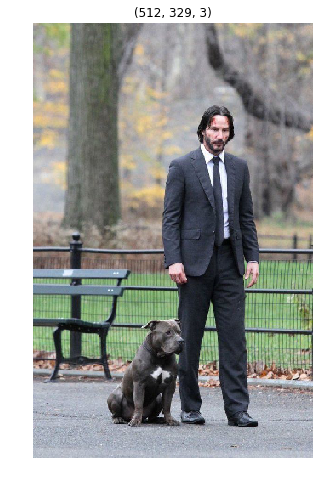

In [3]:
img = load_image("images/john-wick-2-dog.jpg")
print(img.min(), img.max())
show(img)

In [4]:
img = tf.keras.applications.vgg19.preprocess_input(img.astype(float))
img.shape

(1, 512, 329, 3)

# server mrthod

In [5]:
import requests
import json
import base64
headers = {"content-type": "application/json"}
json_response = requests.get('http://localhost:8501/v1/models/style_transfer/metadata', headers=headers)
result = json.loads(json_response.text)
result

{'model_spec': {'name': 'activation', 'signature_name': '', 'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'activation': {'inputs': {'input': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'input_1:0'}},
     'outputs': {'block1_conv2': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '64', 'name': ''}],
        'unknown_rank': False},
       'name': 'block1_conv2/Relu:0'},
      'block1_conv1': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '224', 'name': ''},
         {'size': '64', 'name': ''}],
        'unknown_rank': False},
       'name': 'block1_conv1/Re

In [6]:
from io import BytesIO
buff = BytesIO(img.tobytes())
# new_image_string = base64.b64encode(buff.getvalue())
data = json.dumps(
    {
        'signature_name': 'activation', 
#         'instances':[{'b64':base64.b64encode(buff.getvalue()).decode("utf-8")}]
        'instances':img.tolist()
    }
)
data[:200]

'{"signature_name": "activation", "instances": [[[[64.061, 63.221000000000004, 62.31999999999999], [60.06100000000001, 59.221000000000004, 58.31999999999999], [65.061, 63.221000000000004, 64.32], [62.0'

In [7]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/activation:predict', data=data, headers=headers)
print(json_response.text[:500])
result = json.loads(json_response.text)

{
    "predictions": [
        {
            "block1_conv1": [[[0.0, 15.2565231, 12.598649, 0.0, 41.2077827, 0.0, 0.0, 0.0, 0.0, 33.6712914, 0.0, 11.2576141, 9.31891537, 8.74015617, 8.15275383, 0.0, 1.38315189, 0.0, 0.0, 7.91619, 0.0, 0.0, 0.0, 97.6308, 0.0, 38.4256439, 42.0538445, 18.4550686, 0.0, 0.0, 115.892632, 82.2005692, 0.0, 36.4421654, 101.265022, 150.213181, 0.0, 183.524277, 0.0, 0.0, 16.0318375, 0.0, 26.6279411, 0.0, 0.0, 0.0, 32.2576027, 166.135605, 0.0, 21.0851822, 0.0, 0.0, 0.0, 96.


In [11]:
out_img = np.array(result['predictions'][0]['block1_conv1'])
out_img.shape

(512, 329, 64)

In [12]:
# display images in row format
def display_in_row(features, figname='', max_images=8, images_per_row=8):
    n_features = features.shape[0]
    n_features = min(n_features, max_images)

    h_size = features.shape[1]
    w_size = features.shape[2]
    n_cols = (n_features // (images_per_row+1)) + 1
    images_per_row = min(n_features, images_per_row)
    
    if features.ndim == 4:
        display_grid = np.ones((h_size * n_cols, images_per_row * w_size, features.shape[-1]), dtype=np.float32)
    else:
        display_grid = np.ones((h_size * n_cols, images_per_row * w_size), dtype=np.float32)
        
    # plot on grid
    for col in range(n_cols):
        for row in range(images_per_row):
            if col * images_per_row + row < n_features:
                channel_image = features[col * images_per_row + row, ...]
                display_grid[col * h_size : (col + 1) * h_size, row * w_size : (row + 1) * w_size] = channel_image
    scale = 1.5 / w_size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')  
    plt.tight_layout()
    plt.show()
def deprocess(img):
    img = img.copy()
    # normalized tensor: center at 0., std at 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

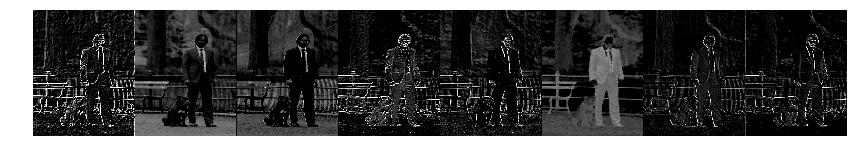

In [13]:
vis_act = [deprocess(out_img[...,:16]).transpose((2, 0, 1))]
for act in vis_act:
    display_in_row(act)

In [14]:
out_img = np.array(result['predictions'][0]['block1_conv2'])
out_img.shape

(512, 329, 64)

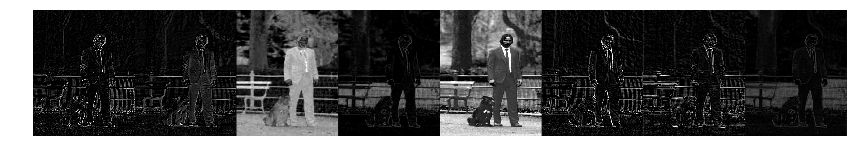

In [17]:
vis_act = [deprocess(out_img[...,:16]).transpose((2, 0, 1))]
for act in vis_act:
    display_in_row(act)